## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [1]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip 
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
100% 812M/812M [00:37<00:00, 24.1MB/s]
100% 812M/812M [00:37<00:00, 22.8MB/s]


In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train6", start_index=0, end_index=8000)
make_subset("validation6", start_index=8000, end_index=8500)
make_subset("test6", start_index=8500, end_index=9000)

**Make sure you change my code to your specific machine to have the correct folder.** 

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [3]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [5]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train6",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation6",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test6",
    image_size=(180, 180),
    batch_size=32)

Found 16000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Note the difference in the number of files for the testing dataset. 

In [7]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [8]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [9]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [10]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [11]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
500/500 [==============================] - 18s 12ms/step - loss: 0.6330 - accuracy: 0.6231 - val_loss: 0.5657 - val_accuracy: 0.6980
Epoch 2/30
500/500 [==============================] - 6s 11ms/step - loss: 0.5177 - accuracy: 0.7437 - val_loss: 0.4527 - val_accuracy: 0.8010
Epoch 3/30
500/500 [==============================] - 6s 11ms/step - loss: 0.4222 - accuracy: 0.8043 - val_loss: 0.3463 - val_accuracy: 0.8490
Epoch 4/30
500/500 [==============================] - 6s 11ms/step - loss: 0.3409 - accuracy: 0.8496 - val_loss: 0.3063 - val_accuracy: 0.8560
Epoch 5/30
500/500 [==============================] - 6s 11ms/step - loss: 0.2745 - accuracy: 0.8841 - val_loss: 0.2677 - val_accuracy: 0.8990
Epoch 6/30
500/500 [==============================] - 6s 11ms/step - loss: 0.2215 - accuracy: 0.9084 - val_loss: 0.2995 - val_accuracy: 0.8860
Epoch 7/30
500/500 [==============================] - 6s 11ms/step - loss: 0.1763 - accuracy: 0.9290 - val_loss: 0.2592 - val_accuracy: 0.903

**Displaying curves of loss and accuracy during training**

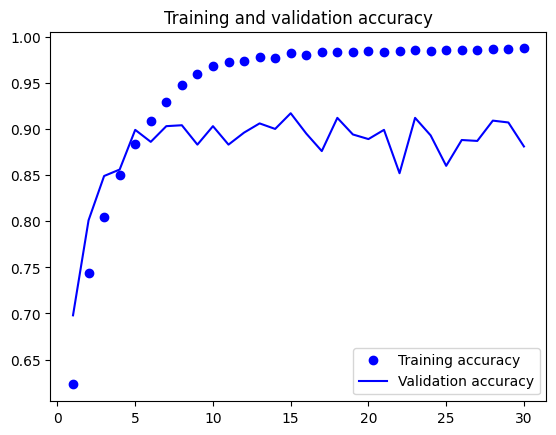

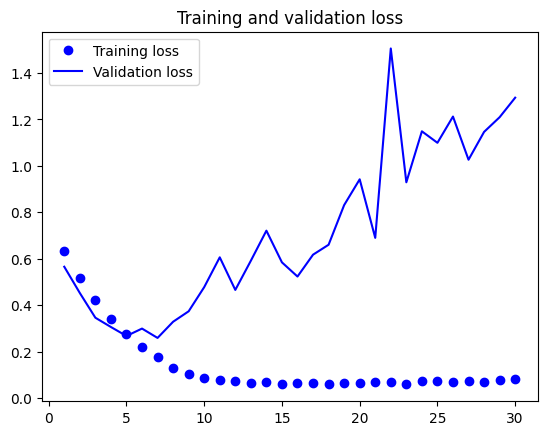

In [13]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [14]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.2932 - accuracy: 0.8920
Test accuracy: 0.892


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

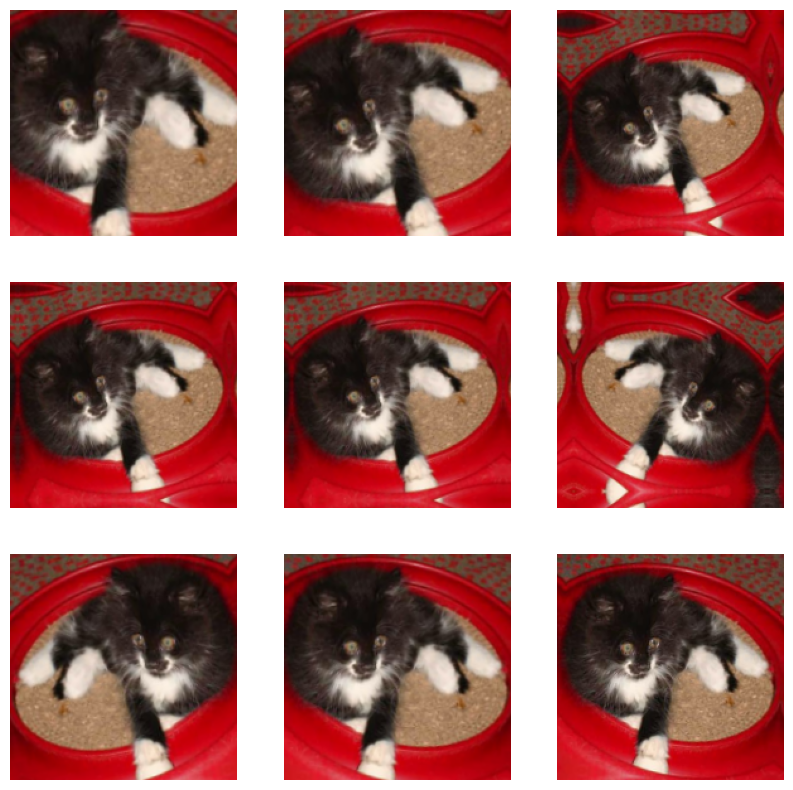

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [18]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=8,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/8
500/500 [==============================] - 9s 13ms/step - loss: 0.6869 - accuracy: 0.5627 - val_loss: 0.6341 - val_accuracy: 0.6630
Epoch 2/8
500/500 [==============================] - 7s 13ms/step - loss: 0.6133 - accuracy: 0.6664 - val_loss: 0.5237 - val_accuracy: 0.7260
Epoch 3/8
500/500 [==============================] - 6s 13ms/step - loss: 0.5473 - accuracy: 0.7248 - val_loss: 0.4968 - val_accuracy: 0.7580
Epoch 4/8
500/500 [==============================] - 7s 13ms/step - loss: 0.5042 - accuracy: 0.7573 - val_loss: 0.4110 - val_accuracy: 0.8060
Epoch 5/8
500/500 [==============================] - 6s 13ms/step - loss: 0.4629 - accuracy: 0.7840 - val_loss: 0.4109 - val_accuracy: 0.8100
Epoch 6/8
500/500 [==============================] - 7s 13ms/step - loss: 0.4249 - accuracy: 0.8027 - val_loss: 0.3522 - val_accuracy: 0.8510
Epoch 7/8
500/500 [==============================] - 7s 13ms/step - loss: 0.3917 - accuracy: 0.8224 - val_loss: 0.2915 - val_accuracy: 0.8690
Epoch 

**Evaluating the model on the test set**

In [19]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 0s 7ms/step - loss: 0.3155 - accuracy: 0.8660
Test accuracy: 0.866


## Leveraging a pretrained model

### Feature extraction with a pretrained model

**Instantiating the VGG16 convolutional base**

In [20]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [21]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [22]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 22ms/step


In [23]:
train_features.shape

(16000, 5, 5, 512)

**Defining and training the densely connected classifier**

In [24]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 6.6122 - accuracy: 0.9606 - val_loss: 4.0203 - val_accuracy: 0.9750
Epoch 2/20
500/500 [==============================] - 1s 3ms/step - loss: 2.8381 - accuracy: 0.9793 - val_loss: 2.5803 - val_accuracy: 0.9770
Epoch 3/20
500/500 [==============================] - 1s 3ms/step - loss: 1.6346 - accuracy: 0.9825 - val_loss: 1.9433 - val_accuracy: 0.9810
Epoch 4/20
500/500 [==============================] - 1s 3ms/step - loss: 0.8555 - accuracy: 0.9885 - val_loss: 1.7844 - val_accuracy: 0.9800
Epoch 5/20
500/500 [==============================] - 1s 3ms/step - loss: 0.7215 - accuracy: 0.9884 - val_loss: 2.1812 - val_accuracy: 0.9790
Epoch 6/20
500/500 [==============================] - 1s 3ms/step - loss: 0.5396 - accuracy: 0.9903 - val_loss: 2.4260 - val_accuracy: 0.9750
Epoch 7/20
500/500 [==============================] - 1s 3ms/step - loss: 0.4687 - accuracy: 0.9921 - val_loss: 2.4867 - val_accuracy: 0.9800
Epoch 

**Plotting the results**

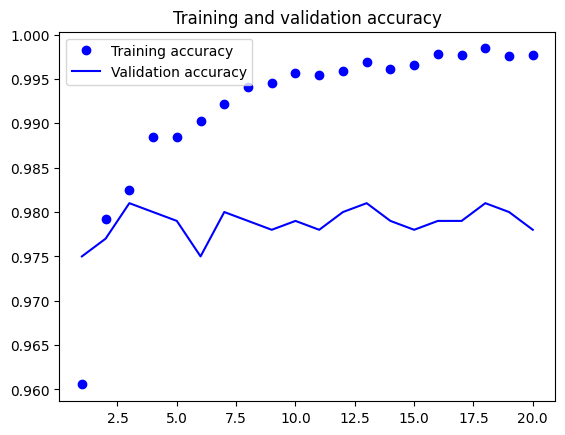

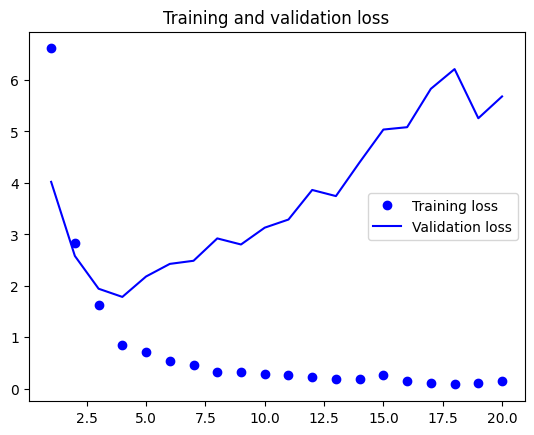

In [25]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [26]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Printing the list of trainable weights before and after freezing**

In [27]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [28]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [29]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
500/500 [==============================] - 12s 21ms/step - loss: 7.4462 - accuracy: 0.9382 - val_loss: 2.1533 - val_accuracy: 0.9710
Epoch 2/50
500/500 [==============================] - 10s 21ms/step - loss: 2.1914 - accuracy: 0.9559 - val_loss: 0.6362 - val_accuracy: 0.9790
Epoch 3/50
500/500 [==============================] - 10s 21ms/step - loss: 0.8160 - accuracy: 0.9528 - val_loss: 0.3786 - val_accuracy: 0.9770
Epoch 4/50
500/500 [==============================] - 10s 20ms/step - loss: 0.6266 - accuracy: 0.9594 - val_loss: 0.4469 - val_accuracy: 0.9820
Epoch 5/50
500/500 [==============================] - 10s 20ms/step - loss: 0.7284 - accuracy: 0.9572 - val_loss: 1.2856 - val_accuracy: 0.9540
Epoch 6/50
500/500 [==============================] - 10s 21ms/step - loss: 0.6541 - accuracy: 0.9609 - val_loss: 0.5869 - val_accuracy: 0.9810
Epoch 7/50
500/500 [==============================] - 10s 20ms/step - loss: 0.7395 - accuracy: 0.9622 - val_loss: 0.4517 - val_accuracy:

**Evaluating the model on the test set**

In [31]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 16ms/step - loss: 0.2232 - accuracy: 0.9850
Test accuracy: 0.985


### Fine-tuning a pretrained model

In [32]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [33]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

**Fine-tuning the model**

In [34]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
500/500 [==============================] - 13s 20ms/step - loss: 0.8618 - accuracy: 0.9693 - val_loss: 0.6766 - val_accuracy: 0.9780
Epoch 2/30
500/500 [==============================] - 10s 20ms/step - loss: 0.4811 - accuracy: 0.9669 - val_loss: 0.3567 - val_accuracy: 0.9750
Epoch 3/30
500/500 [==============================] - 10s 20ms/step - loss: 0.2775 - accuracy: 0.9685 - val_loss: 0.2550 - val_accuracy: 0.9780
Epoch 4/30
500/500 [==============================] - 10s 19ms/step - loss: 0.2127 - accuracy: 0.9688 - val_loss: 0.4467 - val_accuracy: 0.9720
Epoch 5/30
500/500 [==============================] - 10s 20ms/step - loss: 0.1692 - accuracy: 0.9702 - val_loss: 0.1578 - val_accuracy: 0.9770
Epoch 6/30
500/500 [==============================] - 10s 20ms/step - loss: 0.1162 - accuracy: 0.9752 - val_loss: 0.1401 - val_accuracy: 0.9740
Epoch 7/30
500/500 [==============================] - 10s 20ms/step - loss: 0.0960 - accuracy: 0.9756 - val_loss: 0.1255 - val_accuracy:

In [35]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 17ms/step - loss: 0.0968 - accuracy: 0.9880
Test accuracy: 0.988
